<a href="https://colab.research.google.com/github/Kangjuheon/Untargeted_FGSM_MNIST/blob/main/Untargeted_FGSM_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. 라이브러리 설치 및 GPU 연결**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# GPU 연결
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


###**2. 데이터 불러오기**

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.00MB/s]


In [ ]:
# 한 배치 꺼내기
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print("입력 이미지 모양:", example_data.shape)
print("정답 라벨:", example_targets[:10])  # 앞 10개만 출력

입력 이미지 모양: torch.Size([1000, 1, 28, 28])
정답 라벨: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


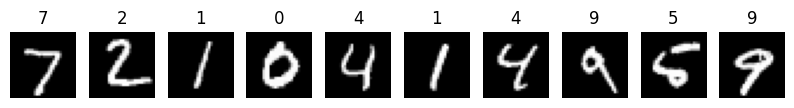

In [ ]:
# 앞에서 가져온 example_data로 이미지 출력
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')  # [0]은 채널 추출
    plt.title(str(example_targets[i].item()))
    plt.axis('off')
plt.show()

###**3. CNN 모델**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

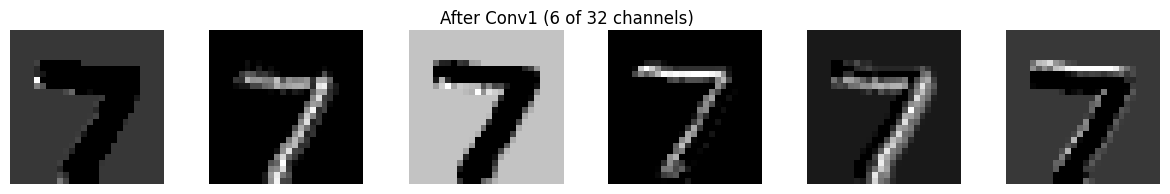

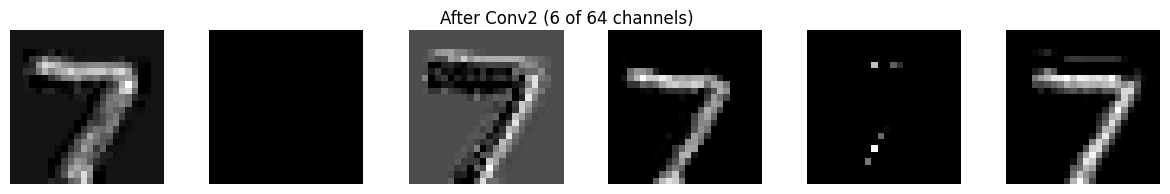

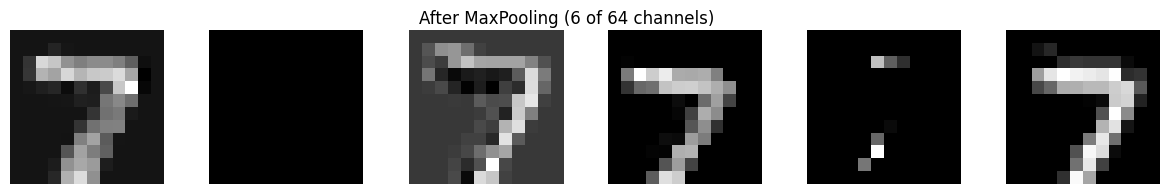

In [ ]:
# 모델에서 중간 결과를 보기 위해 일부만 분리
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.conv1 = model.conv1
        self.conv2 = model.conv2

    def forward(self, x):
        x = F.relu(self.conv1(x))     # conv1 출력
        out1 = x.detach().cpu()       # 저장용
        x = F.relu(self.conv2(x))     # conv2 출력
        out2 = x.detach().cpu()
        x = F.max_pool2d(x, 2)        # pooling 후
        out3 = x.detach().cpu()
        return out1, out2, out3

# 모델 연결
extractor = FeatureExtractor(model).to(device)

# 테스트 이미지 하나 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0).to(device)  # 배치 차원 추가

# 특징 추출
feat1, feat2, feat3 = extractor(img)

# 시각화 함수
def plot_features(features, title, num_channels=6):
    plt.figure(figsize=(15, 2))
    for i in range(num_channels):
        plt.subplot(1, num_channels, i+1)
        plt.imshow(features[0, i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 그리기
plot_features(feat1, "After Conv1 (6 of 32 channels)")
plot_features(feat2, "After Conv2 (6 of 64 channels)")
plot_features(feat3, "After MaxPooling (6 of 64 channels)")


###**4. 모델 학습**

In [ ]:
model = SimpleCNN().to(device) #모델 초기화

In [ ]:
train_losses = []       # 손실 저장 리스트
test_accuracies = []    # 정확도 저장 리스트 추가

def train(model, train_loader, epochs=4):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 정확도 측정 및 저장
        acc = test_accuracy(model, test_loader)
        test_accuracies.append(acc)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += len(data)
    acc = 100 * correct / total
    return acc

train(model, train_loader)

Epoch 1, Loss: 0.1438, Accuracy: 98.38%
Epoch 2, Loss: 0.0433, Accuracy: 98.72%
Epoch 3, Loss: 0.0258, Accuracy: 98.63%
Epoch 4, Loss: 0.0183, Accuracy: 98.95%


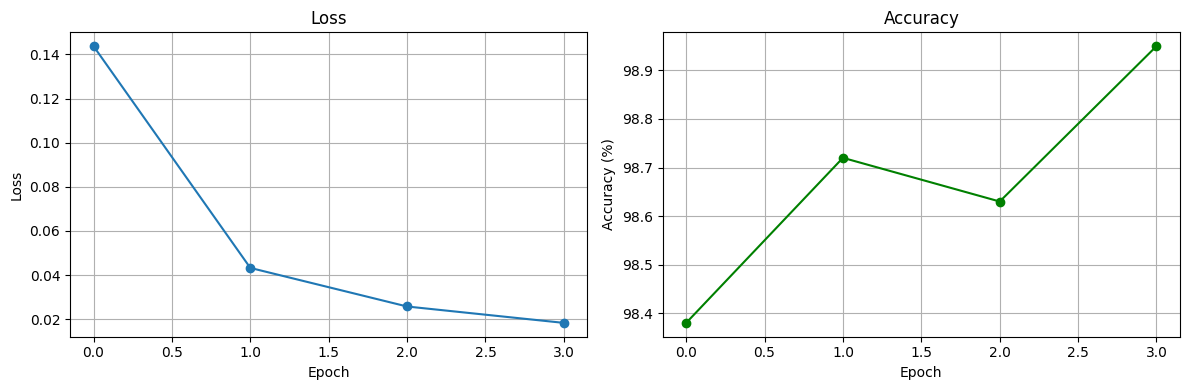

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o', color='green')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

###**5. FGSM (untargeted) 구현**

In [ ]:
def fgsm_untargeted(model, x, label, eps):
    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True
    output = model(x_adv)
    loss = F.cross_entropy(output, label.to(device))
    model.zero_grad()
    loss.backward()
    grad_sign = x_adv.grad.data.sign()
    x_adv = x_adv + eps * grad_sign
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv.detach()

In [ ]:
import matplotlib.pyplot as plt

def visualize_fgsm_multiple(model, images, labels, eps=0.2, num_samples=3):
    model.eval()
    images, labels = images.to(device), labels.to(device)
    x_adv = fgsm_untargeted(model, images, labels, eps)

    outputs_orig = model(images)
    outputs_adv = model(x_adv)

    preds_orig = outputs_orig.argmax(dim=1)
    preds_adv = outputs_adv.argmax(dim=1)

    plt.figure(figsize=(15, num_samples * 2))

    for i in range(num_samples):
        orig = images[i].detach().cpu().squeeze()
        adv = x_adv[i].detach().cpu().squeeze()
        diff = (adv - orig).abs()

        # 원본 이미지
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(orig, cmap='gray')
        plt.title(f"ORIGINER\nLabel: {labels[i].item()}\nPred: {preds_orig[i].item()}")
        plt.axis('off')

        # 공격 이미지
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(adv, cmap='gray')
        plt.title(f"AFTER ATTACK\nPred: {preds_adv[i].item()}")
        plt.axis('off')

        # 차이 이미지
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(diff, cmap='hot')
        plt.title("ATTACK")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

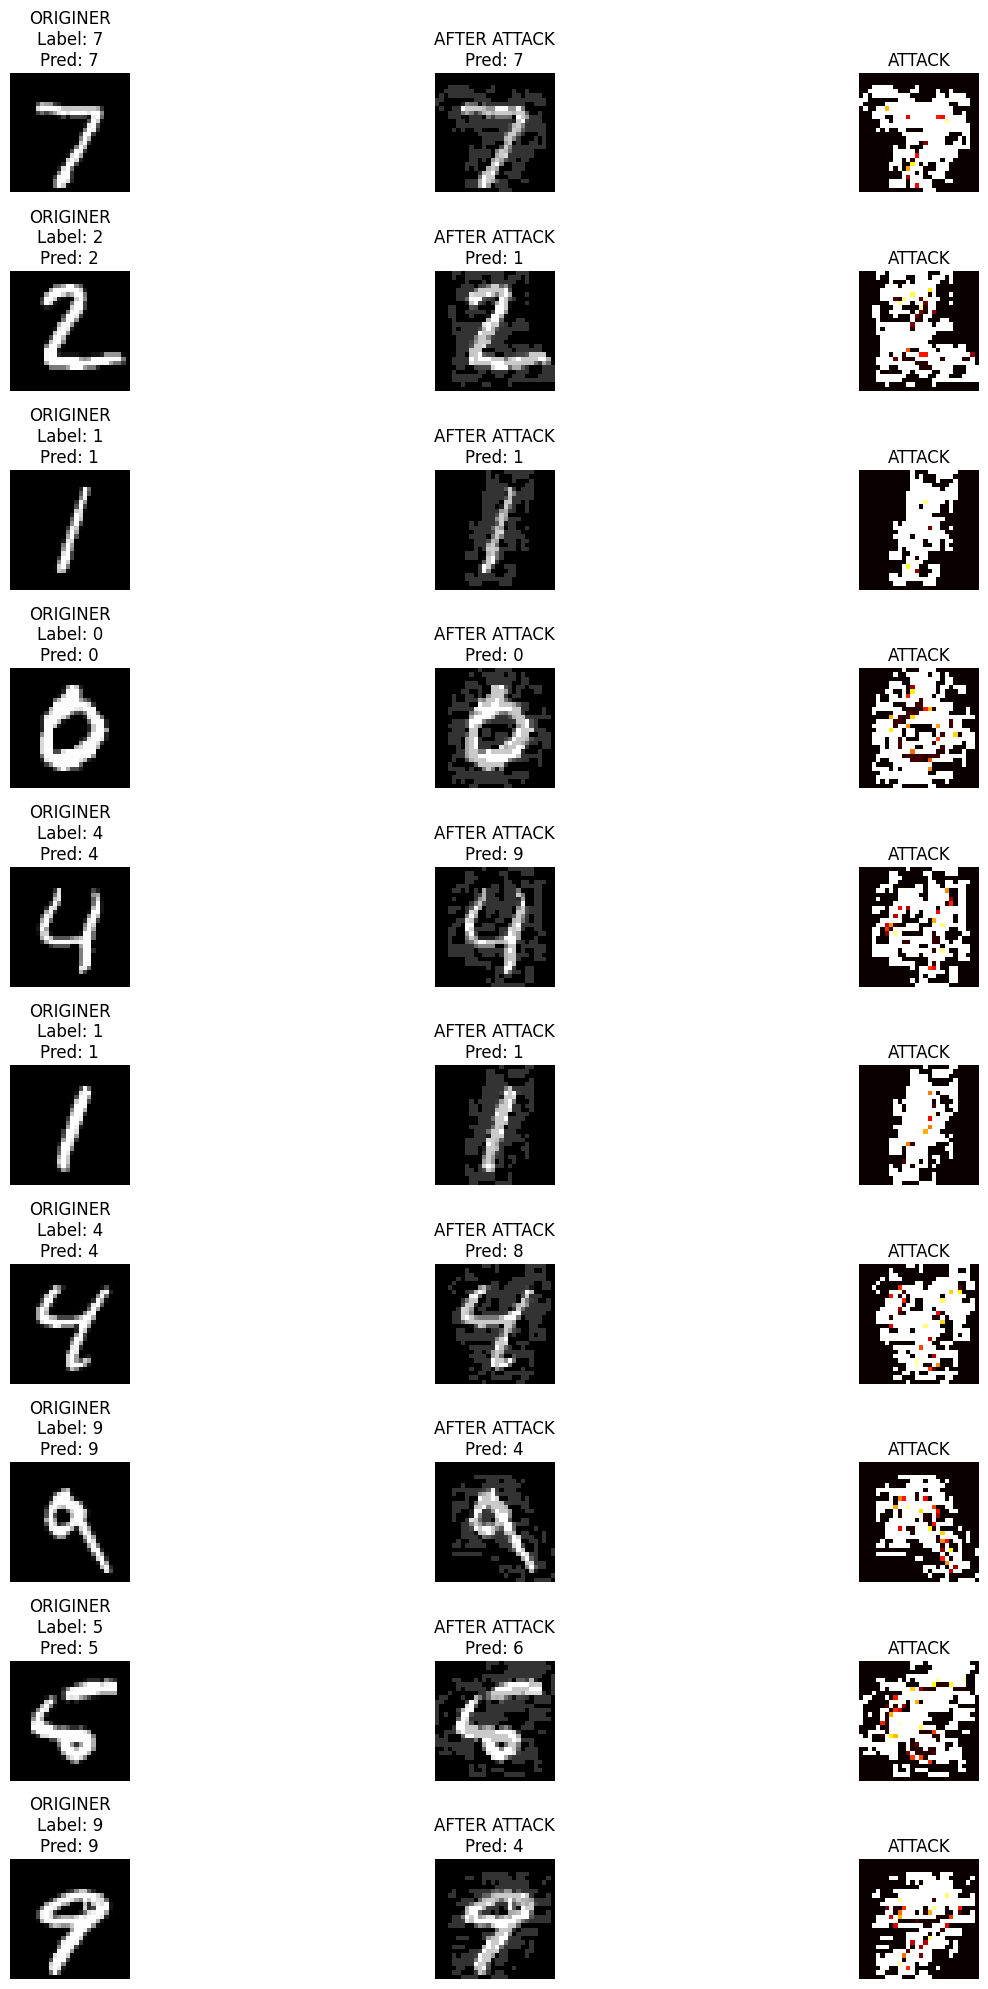

In [ ]:
# 테스트 배치에서 이미지 10 장 꺼내서 시각화
dataiter = iter(test_loader)
images, labels = next(dataiter)

visualize_fgsm_multiple(model, images, labels, eps=0.2, num_samples=10)

###**6. 테스트 함수: 공격 전후 정확도 비교**

In [ ]:
def test(model, test_loader, eps=0.3):
    model.eval()
    correct_clean = 0
    correct_adv = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # 원래 이미지 정확도
        output = model(data)
        pred = output.argmax(dim=1)
        correct_clean += pred.eq(target).sum().item()

        # 공격된 이미지 정확도
        data_adv = fgsm_untargeted(model, data, target, eps)
        output_adv = model(data_adv)
        pred_adv = output_adv.argmax(dim=1)
        correct_adv += pred_adv.eq(target).sum().item()
        total += len(data)

    print(f"Clean Accuracy: {100 * correct_clean / total:.2f}%")
    print(f"Adversarial Accuracy (eps={eps}): {100 * correct_adv / total:.2f}%")

test(model, test_loader, eps=0.3)

Clean Accuracy: 98.95%
Adversarial Accuracy (eps=0.3): 17.30%


In [ ]:
def test_accuracy_vs_eps(model, test_loader, epsilons):
    clean_acc_list = []
    adv_acc_list = []

    for eps in epsilons:
        model.eval()
        correct_clean = 0
        correct_adv = 0
        total = 0

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # 원본 정확도
            output = model(data)
            pred = output.argmax(dim=1)
            correct_clean += pred.eq(target).sum().item()

            # 공격된 정확도
            data_adv = fgsm_untargeted(model, data, target, eps)
            output_adv = model(data_adv)
            pred_adv = output_adv.argmax(dim=1)
            correct_adv += pred_adv.eq(target).sum().item()

            total += len(data)

        clean_acc = 100 * correct_clean / total
        adv_acc = 100 * correct_adv / total

        clean_acc_list.append(clean_acc)
        adv_acc_list.append(adv_acc)

        print(f"ε={eps:.2f} → Clean: {clean_acc:.2f}%, FGSM: {adv_acc:.2f}%")

    return clean_acc_list, adv_acc_list


ε=0.00 → Clean: 98.95%, FGSM: 98.95%
ε=0.06 → Clean: 98.95%, FGSM: 95.63%
ε=0.11 → Clean: 98.95%, FGSM: 85.36%
ε=0.17 → Clean: 98.95%, FGSM: 64.19%
ε=0.22 → Clean: 98.95%, FGSM: 37.70%
ε=0.28 → Clean: 98.95%, FGSM: 21.43%
ε=0.33 → Clean: 98.95%, FGSM: 13.23%
ε=0.39 → Clean: 98.95%, FGSM: 9.53%
ε=0.44 → Clean: 98.95%, FGSM: 8.15%
ε=0.50 → Clean: 98.95%, FGSM: 8.14%


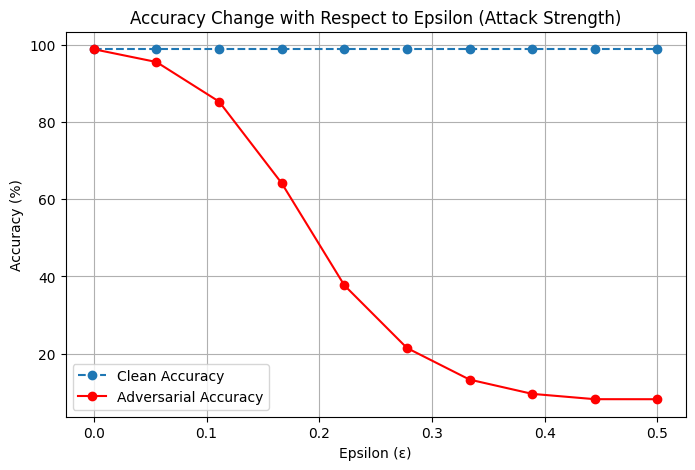

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 다양한 epsilon 값 실험
epsilons = np.linspace(0, 0.5, 10)  # 0부터 0.5까지 10단계

# 정확도 계산
clean_accs, adv_accs = test_accuracy_vs_eps(model, test_loader, epsilons)

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(epsilons, clean_accs, label="Clean Accuracy", linestyle='--', marker='o')
plt.plot(epsilons, adv_accs, label="Adversarial Accuracy", linestyle='-', marker='o', color='red')
plt.title("Accuracy Change with Respect to Epsilon (Attack Strength)")
plt.xlabel("Epsilon (ε)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()


##**7. 인사이트**

- 변형 정도가 0.2~0.3 정도면 봐줄만 한데, Accuracy는 기존 99%에서 절반 이하로 급격하게 감소한다. -> robust 하지 않다.
- MNIST의 Label 중 0과 1에서 Attack이 약한 편으로 보인다.
- Attack이 pixel 전체의 전방위적으로 들어가며 특히 문자 주변에서 일어난다.